In [103]:
from data import Datagenerator, TrainingStats
from copy import deepcopy
from model import LEO, load_model, save_model
from  torch.nn import MSELoss
from easydict import EasyDict as edict
from utils import load_config, check_experiment
from run import train_model
import torch.optim as optim
import argparse
import torch 
import torch.optim
import gc
from utils import display_data_shape, get_named_dict, one_hot_target,\
    softmax, sparse_crossentropy, calc_iou_per_class, log_data, load_config
import matplotlib.pyplot as plt
import numpy as np

## Train

In [104]:
config = load_config()

In [ ]:
leo, meta_data, classes = train_model(config)

## Visualize Predictions

In [4]:
leo

LEO(
  (encoder): Sequential(
    (0): Conv2d(14, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten()
    (5): Linear(in_features=1376256, out_features=400, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=1376256, bias=True)
    (1): ReLU(inplace=True)
    (2): Reshape()
    (3): ConvTranspose2d(28, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
)

In [5]:
classes

['bottle', 'boat', 'chair', 'cat', 'bus', 'aeroplane', 'cow']

In [ ]:
select_class = 0
print("class", classes[select_class], "is selected")
select_sample = 3
batch_data = get_named_dict(meta_data, select_class)
input_data = batch_data.val_data[select_sample].permute(1, 2, 0)
plt.title("First three channels of embeddings is visualized")
plt.imshow(input_data.cpu().detach().numpy()[:,:,:3])

In [ ]:
input_mask = batch_data.val_data_masks[select_sample]
plt.title("ground truth mask")
plt.imshow(input_mask.cpu().detach().numpy(), cmap="gray")

In [ ]:
latents, kl_loss = leo.forward_encoder(batch_data.val_data)
_, _, predictions = leo.forward_decoder(batch_data.val_data, latents, batch_data.val_data_masks)

In [ ]:
plt.title("mask prediction")
plt.imshow(np.argmax(predictions.cpu().detach().numpy()[select_sample], 0), cmap="gray")

In [ ]:
predictions.shape

In [11]:
dataloader = Datagenerator(config, dataset="pascal_voc", data_type="meta_val")
val_meta_data = dataloader.get_batch_data()
class_in_metadata = val_meta_data[-1]

In [12]:
class_in_metadata

['motorbike', 'person', 'dog', 'diningtable', 'horse']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class diningtable is selected


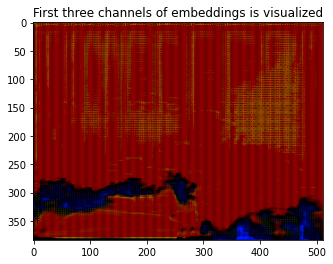

In [77]:
select_class = -2
print("class", class_in_metadata[select_class], "is selected")
batch_data = get_named_dict(val_meta_data, select_class)
input_data = batch_data.val_data[select_sample].permute(1, 2, 0)
plt.title("First three channels of embeddings is visualized")
plt.imshow(input_data.cpu().detach().numpy()[:,:,:3])

In [99]:
latents, kl_loss = leo.forward_encoder(batch_data.tr_data)
tr_loss, predicted_weights, predictions = leo.forward_decoder(batch_data.tr_data, latents, batch_data.tr_data_masks)
val_loss = leo.finetuning_inner_loop(batch_data, tr_loss, predicted_weights)
_, _, predictions = leo.forward_decoder(batch_data.val_data, latents, batch_data.val_data_masks)

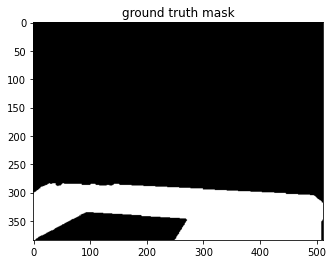

In [100]:
select_sample = 1
def plot_batch_mask(batch_data, select_sample):
    input_mask = batch_data.val_data_masks[select_sample]
    plt.title("ground truth mask")
    plt.imshow(input_mask.cpu().detach().numpy(), cmap="gray")
    return

plot_batch_mask(batch_data, select_sample)

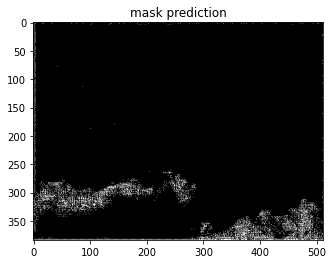

In [101]:
def plot_prediction_mask(pred_mask, select_sample):
    plt.title("mask prediction")
    plt.imshow(np.argmax(pred_mask[select_sample].cpu().detach().numpy(), 0), cmap="gray")
    return

plot_prediction_mask(predictions, select_sample)

In [102]:
calc_iou_per_class(predictions, batch_data.val_data_masks)

0.09633075124392387